In [1]:
'''
MacOS专用字体设置
MacOS 系统中使用的中文字体路径
适用于MacOS15版本
可直接复制到代码中使用
'''
import matplotlib.pyplot as plt
from matplotlib import font_manager
# 设置字体路径
font_path = '/System/Library/Fonts/STHeiti Medium.ttc'

# 加载字体
my_font = font_manager.FontProperties(fname=font_path)

# 设置为默认字体
plt.rcParams['font.family'] = my_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

In [2]:
import pandas as pd

df = pd.read_excel('中医辨证.xlsx')
df.head()

,病人编号,病人症状
0,1,"消化不良,便秘"
1,2,"心悸,失眠"
2,3,"腰疼,脱发,眼干"
3,4,"腹胀,便秘,哮喘,胸闷气短,消化不良"
4,5,"神经衰弱,失眠,月经不调"


In [3]:
transactions = []
for i in df['病人症状'].tolist():
    transactions.append(i.split(','))


In [9]:
all_symptoms = sorted(list(set(sum(transactions, []))))
df_hot = pd.DataFrame([[1 if s in t else 0 for s in all_symptoms] for t in transactions],
                      columns=all_symptoms)

# Apriori

In [4]:
from apyori import apriori
rules = apriori(transactions, min_support=0.1, min_confidence=0.7)
results = list(rules)


In [5]:
for i in results:  # 遍历results中的每一个频繁项集
    for j in i.ordered_statistics:  # 获取频繁项集中的关联规则
        X = j.items_base  # 关联规则的前件
        Y = j.items_add  # 关联规则的后件
        x = ', '.join([item for item in X])  # 连接前件中的元素
        y = ', '.join([item for item in Y])  # 连接后件中的元素
        if x != '':  # 防止出现关联规则前件为空的情况
            print(x + ' -> ' + y)  # 通过字符串拼接的方式更好呈现结果

便秘 -> 消化不良
失眠 -> 月经不调
神经衰弱 -> 消化不良
脱发 -> 眼干
腰疼 -> 眼干
心悸, 失眠 -> 月经不调
心悸, 神经衰弱 -> 消化不良


In [6]:
data = []
for item in results:
    for stat in item.ordered_statistics:
        if len(stat.items_base) > 0:
            data.append({
                '前件': ', '.join(stat.items_base),
                '后件': ', '.join(stat.items_add),
                '支持度': round(item.support, 3),
                '置信度': round(stat.confidence, 3),
                '提升度': round(stat.lift, 3)
            })

In [ ]:
df_rules = pd.DataFrame(data)
df_rules = df_rules.sort_values(by='提升度', ascending=False)

print(df_rules.head(10))

         前件    后件    支持度    置信度    提升度
3        脱发    眼干  0.143  0.947  3.045
4        腰疼    眼干  0.136  0.850  2.733
6  心悸, 神经衰弱  消化不良  0.100  0.926  2.692
2      神经衰弱  消化不良  0.164  0.872  2.536
0        便秘  消化不良  0.160  0.870  2.528
1        失眠  月经不调  0.318  0.809  1.672
5    心悸, 失眠  月经不调  0.167  0.766  1.583


# w2v

In [8]:
from gensim.models import Word2Vec

In [10]:
model = Word2Vec(sentences=transactions, vector_size=50, window=3, min_count=1, sg=1)
symptom = all_symptoms[0]
print(f"与『{symptom}』最相似的症状：")
print(model.wv.most_similar(symptom, topn=5))

与『便秘』最相似的症状：
[('哮喘', 0.32900574803352356), ('神经衰弱', 0.30445194244384766), ('腰疼', 0.29307475686073303), ('心悸', 0.29051631689071655), ('失眠', 0.2569029927253723)]


# Kmeans

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(df_hot)
df['聚类标签'] = labels

/opt/anaconda3/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [16]:
df.head()

,病人编号,病人症状,聚类标签
0,1,"消化不良,便秘",1
1,2,"心悸,失眠",3
2,3,"腰疼,脱发,眼干",0
3,4,"腹胀,便秘,哮喘,胸闷气短,消化不良",2
4,5,"神经衰弱,失眠,月经不调",3


# PCA

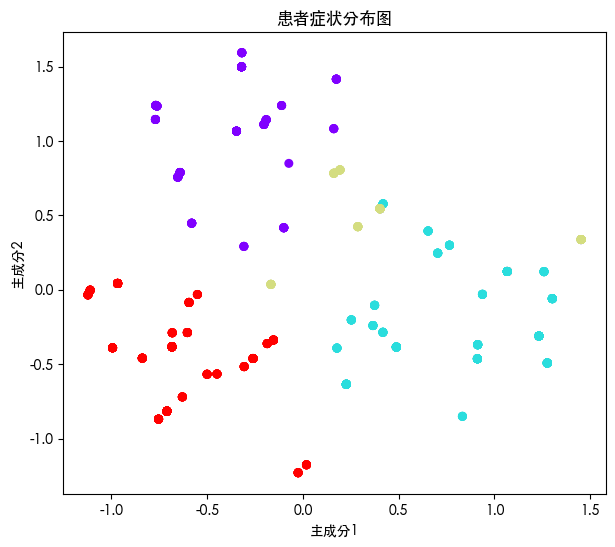

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_hot)
plt.figure(figsize=(7,6))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=labels, cmap='rainbow', s=30)
plt.title("患者症状分布图")
plt.xlabel("主成分1")
plt.ylabel("主成分2")
plt.show()

# FP-Growth

In [18]:
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

freq_fp = fpgrowth(df_hot, min_support=0.05, use_colnames=True)
rules_fp = association_rules(freq_fp, metric="confidence", min_threshold=0.6)
rules_fp.sort_values(by='lift', ascending=False, inplace=True)

/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [19]:
rules_fp.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,"(腹胀, 消化不良)",(便秘),0.076,0.184,0.076,1.000000,5.434783,1.0,0.062016,inf,0.883117,0.413043,1.000000,0.706522
23,(腹胀),"(便秘, 消化不良)",0.092,0.160,0.076,0.826087,5.163043,1.0,0.061280,4.830000,0.888013,0.431818,0.792961,0.650543
18,(胸闷气短),(哮喘),0.140,0.124,0.088,0.628571,5.069124,1.0,0.070640,2.358462,0.933404,0.500000,0.575995,0.669124
17,(哮喘),(胸闷气短),0.124,0.140,0.088,0.709677,5.069124,1.0,0.070640,2.962222,0.916355,0.500000,0.662416,0.669124
19,(腹胀),(便秘),0.092,0.184,0.084,0.913043,4.962193,1.0,0.067072,9.384000,0.879379,0.437500,0.893436,0.684783
